# 用scikit-learn学习主成分分析(PCA)

## 1. scikit-learn PCA类介绍

在scikit-learn中，与PCA相关的类都在sklearn.decomposition包中。最常用的PCA类就是sklearn.decomposition.PCA，我们下面主要也会讲解基于这个类的使用的方法。

除了PCA类以外，最常用的PCA相关类还有KernelPCA类，在原理篇我们也讲到了，它主要用于非线性数据的降维，需要用到核技巧。因此在使用的时候需要选择合适的核函数并对核函数的参数进行调参。

另外一个常用的PCA相关类是IncrementalPCA类，它主要是为了解决单机内存限制的。有时候我们的样本量可能是上百万+，维度可能也是上千，直接去拟合数据可能会让内存爆掉， 此时我们可以用IncrementalPCA类来解决这个问题。IncrementalPCA先将数据分成多个batch，然后对每个batch依次递增调用partial_fit函数，这样一步步的得到最终的样本最优降维。

此外还有SparsePCA和MiniBatchSparsePCA。他们和上面讲到的PCA类的区别主要是使用了L1的正则化，这样可以将很多非主要成分的影响度降为0，这样在PCA降维的时候我们仅仅需要对那些相对比较主要的成分进行PCA降维，避免了一些噪声之类的因素对我们PCA降维的影响。SparsePCA和MiniBatchSparsePCA之间的区别则是MiniBatchSparsePCA通过使用一部分样本特征和给定的迭代次数来进行PCA降维，以解决在大样本时特征分解过慢的问题，当然，代价就是PCA降维的精确度可能会降低。使用SparsePCA和MiniBatchSparsePCA需要对L1正则化参数进行调参。

## 2. sklearn.decomposition.PCA参数介绍

下面我们主要基于sklearn.decomposition.PCA来讲解如何使用scikit-learn进行PCA降维。PCA类基本不需要调参，一般来说，我们只需要指定我们需要降维到的维度，或者我们希望降维后的主成分的方差和占原始维度所有特征方差和的比例阈值就可以了。

现在我们对sklearn.decomposition.PCA的主要参数做一个介绍：

1）n_components：这个参数可以帮我们指定希望PCA降维后的特征维度数目。最常用的做法是直接指定降维到的维度数目，此时n_components是一个大于等于1的整数。当然，我们也可以指定主成分的方差和所占的最小比例阈值，让PCA类自己去根据样本特征方差来决定降维到的维度数，此时n_components是一个（0，1]之间的数。当然，我们还可以将参数设置为"mle", 此时PCA类会用MLE算法根据特征的方差分布情况自己去选择一定数量的主成分特征来降维。我们也可以用默认值，即不输入n_components，此时n_components=min(样本数，特征数)。

2）whiten ：判断是否进行白化。所谓白化，就是对降维后的数据的每个特征进行归一化，让方差都为1.对于PCA降维本身来说，一般不需要白化。如果你PCA降维后有后续的数据处理动作，可以考虑白化。默认值是False，即不进行白化。

3）svd_solver：即指定奇异值分解SVD的方法，由于特征分解是奇异值分解SVD的一个特例，一般的PCA库都是基于SVD实现的。有4个可以选择的值：{‘auto’, ‘full’, ‘arpack’, ‘randomized’}。randomized一般适用于数据量大，数据维度多同时主成分数目比例又较低的PCA降维，它使用了一些加快SVD的随机算法。 full则是传统意义上的SVD，使用了scipy库对应的实现。arpack和randomized的适用场景类似，区别是randomized使用的是scikit-learn自己的SVD实现，而arpack直接使用了scipy库的sparse SVD实现。默认是auto，即PCA类会自己去在前面讲到的三种算法里面去权衡，选择一个合适的SVD算法来降维。一般来说，使用默认值就够了。

除了这些输入参数外，有两个PCA类的成员值得关注。第一个是explained_variance_，它代表降维后的各主成分的方差值。方差值越大，则说明越是重要的主成分。第二个是explained_variance_ratio_，它代表降维后的各主成分的方差值占总方差值的比例，这个比例越大，则越是重要的主成分。

## 3. PCA实例

下面我们用一个实例来学习下scikit-learn中的PCA类使用。为了方便的可视化让大家有一个直观的认识，我们这里使用了三维的数据来降维。

完整代码参见我的github: https://github.com/ljpzzz/machinelearning/blob/master/classic-machine-learning/pca.ipynb

首先我们生成随机数据并可视化，代码如下：

F:\anaconda\lib\site-packages\matplotlib\collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


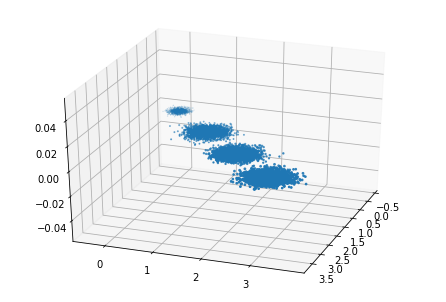

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.datasets.samples_generator import make_blobs
# X为样本特征，Y为样本簇类别， 共1000个样本，每个样本3个特征，共4个簇
X, y = make_blobs(n_samples=10000, n_features=3, centers=[[3,3, 3], [0,0,0], [1,1,1], [2,2,2]], cluster_std=[0.2, 0.1, 0.2, 0.2], 
                  random_state =9)
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
plt.scatter(X[:, 0], X[:, 1], X[:, 2],marker='o')

我们先不降维，只对数据进行投影，看看投影后的三个维度的方差分布，代码如下：

In [2]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_)

[0.98318212 0.00850037 0.00831751]
[3.78521638 0.03272613 0.03202212]


可以看出投影后三个特征维度的方差比例大约为98.3%：0.8%：0.8%。投影后第一个特征占了绝大多数的主成分比例。

现在我们来进行降维，从三维降到2维，代码如下

In [3]:
pca = PCA(n_components=2)
pca.fit(X)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_)

[0.98318212 0.00850037]
[3.78521638 0.03272613]


这个结果其实可以预料，因为上面三个投影后的特征维度的方差分别为：[ 3.78483785  0.03272285  0.03201892]，投影到二维后选择的肯定是前两个特征，而抛弃第三个特征。

为了有个直观的认识，我们看看此时转化后的数据分布，代码如下：

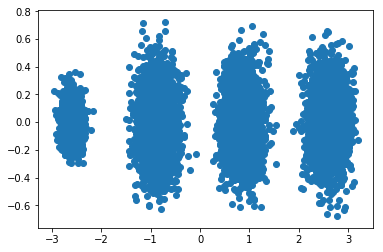

In [4]:
X_new = pca.transform(X)
plt.scatter(X_new[:, 0], X_new[:, 1],marker='o')
plt.show()

可见降维后的数据依然可以很清楚的看到我们之前三维图中的4个簇。

现在我们看看不直接指定降维的维度，而指定降维后的主成分方差和比例。

In [5]:
pca = PCA(n_components=0.95)
pca.fit(X)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_)
print (pca.n_components_)

[0.98318212]
[3.78521638]
1


可见只有第一个投影特征被保留。这也很好理解，我们的第一个主成分占投影特征的方差比例高达98%。只选择这一个特征维度便可以满足95%的阈值。

我们现在选择阈值99%看看，代码如下：

In [6]:
pca = PCA(n_components=0.99)
pca.fit(X)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_)
print (pca.n_components_)

[0.98318212 0.00850037]
[3.78521638 0.03272613]
2


这个结果也很好理解，因为我们第一个主成分占了98.3%的方差比例，第二个主成分占了0.8%的方差比例，两者一起可以满足我们的阈值。

最后我们看看让MLE算法自己选择降维维度的效果，代码如下：

In [7]:
pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_)
print (pca.n_components_)

[0.98318212]
[3.78521638]
1


可见由于我们的数据的第一个投影特征的方差占比高达98.3%，MLE算法只保留了我们的第一个特征。

文章转载自：
[博客园 刘建平 Pinard 用scikit-learn学习主成分分析(PCA)](https://www.cnblogs.com/pinard/p/6243025.html)